# DSCI 617 – Homework 07
**Felix Asare**

In [0]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
 
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr
 
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
 
 
spark = SparkSession.builder.getOrCreate()

## Problem 1: Decision Tree Classification

<pre>
+-----+-----+-----+-----+-----+------------+-----------+
|  x0 |  x1 |  x2 |  x3 |  x4 | prediction | Leaf Node |
+-----+-----+-----+-----+-----+------------+-----------+
| 3.7 | 5.6 | 3.6 | 2.0 | 1.0 |    0.0     |     4     |
| 8.2 | 4.2 | 2.1 | 2.0 | 0.0 |    2.0     |     8     |
| 5.4 | 3.9 | 4.9 | 1.0 | 1.0 |    1.0     |     6     |
| 2.8 | 6.1 | 8.1 | 0.0 | 0.0 |    2.0     |     2     |
+-----+-----+-----+-----+-----+------------+-----------+
</pre>


## Problem 2: Random Forest Classification

- Tree Model 1 Prediction: 0.0
- Tree Model 2 Prediction: 0.0
- Tree Model 3 Prediction: 1.0
- Random Forest Prediction: 0.0

## Problem 3: Load and Process Stroke Data

In [0]:
# Create Schema
stroke_df = (
    spark.read
    .option("delimiter", ",")
    .option("header", True)
    .schema(
        'gender STRING, age DOUBLE, hypertension INT, heart_disease INT, ever_married STRING, work_type STRING, residence_type STRING, avg_glucose_level DOUBLE, bmi DOUBLE, smoking_status STRING, stroke INT'
    )
    .csv('/FileStore/tables/stroke_data.csv')
)

stroke_df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [0]:
# Seperating Numeric and Categorical Columns
num_features = ['age', 'avg_glucose_level', 'bmi']
cat_features = [c for c in stroke_df.columns[:-1] if c not in num_features]


#Integer encoding 
ix_features = [c + '_ix' for c in cat_features]

# String Indexing
label_indexer = StringIndexer(inputCol='stroke', outputCol='label')
feature_indexer = StringIndexer(inputCols=cat_features, outputCols=ix_features)

# Vector Assembler
assember = VectorAssembler(inputCols=num_features+ix_features, outputCol='features')

In [0]:
# Create pipeline
pipeline = Pipeline(stages=[label_indexer, feature_indexer, assember]).fit(stroke_df)
train = pipeline.transform(stroke_df)
#Persist train
train.persist()

# Show first 10 rows
train.show(10, truncate=False)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----+---------+---------------+----------------+---------------+------------+-----------------+-----------------+----------------------------------------------+
|gender|age |hypertension|heart_disease|ever_married|work_type    |residence_type|avg_glucose_level|bmi |smoking_status |stroke|label|gender_ix|hypertension_ix|heart_disease_ix|ever_married_ix|work_type_ix|residence_type_ix|smoking_status_ix|features                                      |
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+-----+---------+---------------+----------------+---------------+------------+-----------------+-----------------+----------------------------------------------+
|Female|13.0|0           |0            |No          |Private      |Urban         |77.63            |31.7|never smoked   |0     |0.

## Problem 4: Hyperparameter Tuning for Decision Trees

In [0]:
# Multi Classifier to calculate accuracy
accuracy_eval = MulticlassClassificationEvaluator(
    predictionCol='prediction', labelCol='label', metricName='accuracy')

In [0]:
# Create Decision Tree Classifier with seed 1
dtree = DecisionTreeClassifier(labelCol='label', featuresCol='features', seed=1)

# Parameter Grid
param_grid = (ParamGridBuilder()
              .addGrid(dtree.maxDepth, [2, 4, 6, 8, 10, 12, 14, 16] )
              .addGrid(dtree.minInstancesPerNode, [4, 8, 16, 32])
             ).build()

# Create CrossValidator
dtree_cv = CrossValidator(estimator=dtree, estimatorParamMaps=param_grid, evaluator=accuracy_eval, numFolds=5, seed=1)

# Fit CrossValidator to train
cv_model = dtree_cv.fit(train)

In [0]:
# Optimize the model
model = cv_model.bestModel

# Optimal parameters
maxDepth = model.getMaxDepth()
minInstancesPerNode = model.getMinInstancesPerNode()

print('Max CV Score:   ', round(max(cv_model.avgMetrics),4))
print('Optimal Depth:  ', maxDepth)
print('Optimal MinInst:', minInstancesPerNode)


Max CV Score:    0.7895
Optimal Depth:   6
Optimal MinInst: 16


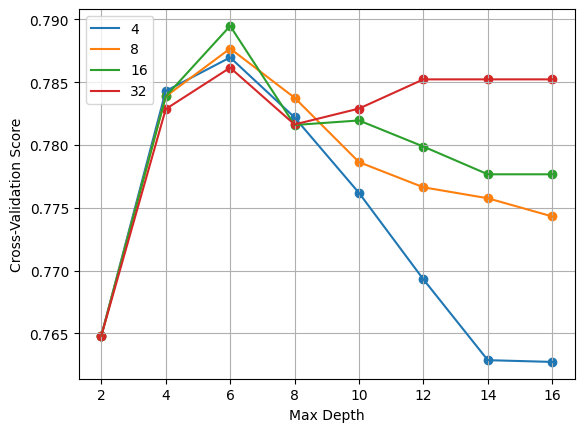

In [0]:
model_params = cv_model.getEstimatorParamMaps()
dt_cv_summary_list = []
for param_set, acc in zip(model_params, cv_model.avgMetrics):
    new_set = list(param_set.values()) + [acc] 
    dt_cv_summary_list.append(new_set)
cv_summary = pd.DataFrame(dt_cv_summary_list, 
                          columns=['maxDepth', 'minInst', 'acc'])
for mi in cv_summary.minInst.unique():
    sel = cv_summary.minInst == mi 
    plt.plot(cv_summary.maxDepth[sel], cv_summary.acc[sel], label=mi) 
    plt.scatter(cv_summary.maxDepth[sel], cv_summary.acc[sel])
plt.legend()
plt.grid()
plt.xticks(range(2,18,2)) 
plt.xlabel('Max Depth') 
plt.ylabel('Cross-Validation Score') 
plt.show()

## Problem 5: Structure of Final Model

In [0]:
# Print deBugging information
print(model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_917c84c0bf0b, depth=6, numNodes=53, numClasses=2, numFeatures=10
  If (feature 0 <= 56.5)
   If (feature 5 in {1.0})
    If (feature 9 in {3.0})
     Predict: 0.0
    Else (feature 9 not in {3.0})
     If (feature 4 in {1.0})
      Predict: 1.0
     Else (feature 4 not in {1.0})
      If (feature 2 <= 27.15)
       Predict: 1.0
      Else (feature 2 > 27.15)
       If (feature 3 in {1.0})
        Predict: 0.0
       Else (feature 3 not in {1.0})
        Predict: 1.0
   Else (feature 5 not in {1.0})
    If (feature 0 <= 43.5)
     If (feature 4 in {1.0})
      If (feature 2 <= 28.15)
       Predict: 1.0
      Else (feature 2 > 28.15)
       Predict: 0.0
     Else (feature 4 not in {1.0})
      Predict: 0.0
    Else (feature 0 > 43.5)
     If (feature 1 <= 156.44)
      If (feature 4 in {1.0})
       If (feature 9 in {0.0,2.0,3.0})
        Predict: 0.0
       Else (feature 9 not in {0.0,2.0,3.0})
        Predict: 1.0
      Else 

In [0]:
# Combine features
features = num_features + cat_features

# Print features
print(features)

['age', 'avg_glucose_level', 'bmi', 'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status']


- First Feature Used in Tree: age
- Features Unused in Tree: ever_married, work_type, residence_type

In [0]:
feature_importances = model.featureImportances

# Step 3: Create a list of feature name, importance
feature_importance_list = [(feature, float(feature_importances[idx])) for idx, feature in enumerate(features)]

# Convert list to a DataFrame
importance_df = spark.createDataFrame(feature_importance_list, schema=["feature", "importance"])

# Step 5: Show the DataFrame
importance_df.show(truncate=False)

+-----------------+--------------------+
|feature          |importance          |
+-----------------+--------------------+
|age              |0.7805365372711884  |
|avg_glucose_level|0.06442225566134731 |
|bmi              |0.022221333075889322|
|gender           |0.004707540255107664|
|hypertension     |0.03084441895517952 |
|heart_disease    |0.088193834022943   |
|ever_married     |0.0                 |
|work_type        |0.0                 |
|residence_type   |0.0                 |
|smoking_status   |0.009074080758344689|
+-----------------+--------------------+



## Problem 6: Applying the Model to New Data

In [0]:
# Create schema
schema = 'gender STRING, age DOUBLE, hypertension INT, heart_disease INT, ever_married STRING, work_type STRING, residence_type STRING, avg_glucose_level DOUBLE, bmi DOUBLE, smoking_status STRING'

# Create the data
data = [
    ("Female", 42.0, 1, 0, "No", "Private", "Urban", 182.1, 26.8, "smokes"),
    ("Female", 64.0, 1, 1, "Yes", "Self-employed", "Rural", 171.5, 32.5, "formerly smoked"),
    ("Male", 37.0, 0, 0, "Yes", "Private", "Rural", 79.2, 18.4, "Unknown"),
    ("Male", 72.0, 0, 1, "No", "Govt_job", "Urban", 125.7, 19.4, "never smoked")
]

# Create DataFrame with schema
new_data = spark.createDataFrame(data, schema=schema)

# Display DataFrame
new_data.show()

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|residence_type|avg_glucose_level| bmi| smoking_status|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+
|Female|42.0|           1|            0|          No|      Private|         Urban|            182.1|26.8|         smokes|
|Female|64.0|           1|            1|         Yes|Self-employed|         Rural|            171.5|32.5|formerly smoked|
|  Male|37.0|           0|            0|         Yes|      Private|         Rural|             79.2|18.4|        Unknown|
|  Male|72.0|           0|            1|          No|     Govt_job|         Urban|            125.7|19.4|   never smoked|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+



In [0]:
# Create pipeline
new_data_pipeline = pipeline.transform(new_data)

# Use the model to make predictions
predictions = model.transform(new_data_pipeline)

# Display predictions
predictions.select("probability", "prediction").show(truncate=False)


+-----------------------------------------+----------+
|probability                              |prediction|
+-----------------------------------------+----------+
|[0.3125,0.6875]                          |1.0       |
|[0.3755020080321285,0.6244979919678715]  |1.0       |
|[0.9767441860465116,0.023255813953488372]|0.0       |
|[0.3755020080321285,0.6244979919678715]  |1.0       |
+-----------------------------------------+----------+

